### Imports

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split,\
    GridSearchCV, cross_val_score
from sklearn.dummy import DummyClassifier 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder,\
    FunctionTransformer, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,\
    GradientBoostingClassifier, AdaBoostClassifier,\
    BaggingClassifier, ExtraTreesClassifier,\
    VotingClassifier, StackingClassifier
from sklearn.metrics import plot_confusion_matrix, recall_score,\
    accuracy_score, precision_score, f1_score
from sklearn.metrics import plot_roc_curve

import xgboost

import pickle

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

#https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/
from sklearn.metrics import roc_curve
from numpy import sqrt, argmax

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

### Problem Description

My goal is to predict how likely individuals are to receive their H1N1 and seasonal flu vaccines. Specifically, I'll be predicting two probabilities: one for h1n1_vaccine and one for seasonal_vaccine.

#### Business Problem 

Mayo Clinic: 

Can we predict who will get the seasonal vaccine?

What are the most significant features in determining whether or not an individual will get vaccinated? 

How can we get more people to get vaccinated?

### Data

In [3]:
submission_format = pd.read_csv('../Data/submission_format.csv')
submission_format.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26708 entries, 0 to 26707
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   respondent_id     26708 non-null  int64  
 1   h1n1_vaccine      26708 non-null  float64
 2   seasonal_vaccine  26708 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 626.1 KB


The submission_format.csv is an example of how my submission should be submitted.

In [4]:
test_set_features = pd.read_csv('../Data/test_set_features.csv')
test_set_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26708 entries, 0 to 26707
Data columns (total 36 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                26708 non-null  int64  
 1   h1n1_concern                 26623 non-null  float64
 2   h1n1_knowledge               26586 non-null  float64
 3   behavioral_antiviral_meds    26629 non-null  float64
 4   behavioral_avoidance         26495 non-null  float64
 5   behavioral_face_mask         26689 non-null  float64
 6   behavioral_wash_hands        26668 non-null  float64
 7   behavioral_large_gatherings  26636 non-null  float64
 8   behavioral_outside_home      26626 non-null  float64
 9   behavioral_touch_face        26580 non-null  float64
 10  doctor_recc_h1n1             24548 non-null  float64
 11  doctor_recc_seasonal         24548 non-null  float64
 12  chronic_med_condition        25776 non-null  float64
 13  child_under_6_mo

The test_set_features.csv will be used to run my model and produce a predictive csv in the format of submission_format. 

In [5]:
training_set_features = pd.read_csv('../Data/training_set_features.csv')
training_set_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 36 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                26707 non-null  int64  
 1   h1n1_concern                 26615 non-null  float64
 2   h1n1_knowledge               26591 non-null  float64
 3   behavioral_antiviral_meds    26636 non-null  float64
 4   behavioral_avoidance         26499 non-null  float64
 5   behavioral_face_mask         26688 non-null  float64
 6   behavioral_wash_hands        26665 non-null  float64
 7   behavioral_large_gatherings  26620 non-null  float64
 8   behavioral_outside_home      26625 non-null  float64
 9   behavioral_touch_face        26579 non-null  float64
 10  doctor_recc_h1n1             24547 non-null  float64
 11  doctor_recc_seasonal         24547 non-null  float64
 12  chronic_med_condition        25736 non-null  float64
 13  child_under_6_mo

In [6]:
training_set_labels = pd.read_csv('../Data/training_set_labels.csv')
training_set_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   respondent_id     26707 non-null  int64
 1   h1n1_vaccine      26707 non-null  int64
 2   seasonal_vaccine  26707 non-null  int64
dtypes: int64(3)
memory usage: 626.1 KB


The training_set_features and is the dataset used to predict the actual training_set_labels. They are already split, however I will be rejoining for any cleaning I find necessary and splitting again in a format that is more convenient since there is two target variables. 

In [7]:
complete_data = pd.merge(training_set_features, training_set_labels, on='respondent_id')

In [8]:
complete_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 38 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                26707 non-null  int64  
 1   h1n1_concern                 26615 non-null  float64
 2   h1n1_knowledge               26591 non-null  float64
 3   behavioral_antiviral_meds    26636 non-null  float64
 4   behavioral_avoidance         26499 non-null  float64
 5   behavioral_face_mask         26688 non-null  float64
 6   behavioral_wash_hands        26665 non-null  float64
 7   behavioral_large_gatherings  26620 non-null  float64
 8   behavioral_outside_home      26625 non-null  float64
 9   behavioral_touch_face        26579 non-null  float64
 10  doctor_recc_h1n1             24547 non-null  float64
 11  doctor_recc_seasonal         24547 non-null  float64
 12  chronic_med_condition        25736 non-null  float64
 13  child_under_6_mo

In [9]:
complete_data.isna().sum().sort_values(ascending=False)

employment_occupation          13470
employment_industry            13330
health_insurance               12274
income_poverty                  4423
doctor_recc_h1n1                2160
doctor_recc_seasonal            2160
rent_or_own                     2042
employment_status               1463
marital_status                  1408
education                       1407
chronic_med_condition            971
child_under_6_months             820
health_worker                    804
opinion_seas_sick_from_vacc      537
opinion_seas_risk                514
opinion_seas_vacc_effective      462
opinion_h1n1_sick_from_vacc      395
opinion_h1n1_vacc_effective      391
opinion_h1n1_risk                388
household_adults                 249
household_children               249
behavioral_avoidance             208
behavioral_touch_face            128
h1n1_knowledge                   116
h1n1_concern                      92
behavioral_large_gatherings       87
behavioral_outside_home           82
b

If the employment_status column has a value of Not in Labor Force, then columns employment_industry and employment_occupation will have NA's. 

Values in columns employment_industry and employment_occupation are represented as short random character strings. 

Filling NA's in employment_occupation and employment_industry associated with "not in labor force" with because they would otherwise be imputed as the most frequent occupation or industry.

Filling Unemployed with "not in labor force".

In [10]:
complete_data['employment_status'].replace("Unemployed", "Not in Labor Force", inplace=True)
complete_data.loc[complete_data['employment_status'] == "Not in Labor Force", 'employment_industry'] = "Not in Labor Force"
complete_data.loc[complete_data['employment_status'] == "Not in Labor Force", 'employment_occupation'] = "Not in Labor Force"

In [11]:
complete_data.filter(['employment_status', 'employment_occupation', 'employment_industry'])

,employment_status,employment_occupation,employment_industry
0,Not in Labor Force,Not in Labor Force,Not in Labor Force
1,Employed,xgwztkwe,pxcmvdjn
2,Employed,xtkaffoo,rucpziij
3,Not in Labor Force,Not in Labor Force,Not in Labor Force
4,Employed,emcorrxb,wxleyezf
...,...,...,...
26702,Not in Labor Force,Not in Labor Force,Not in Labor Force
26703,Employed,cmhcxjea,fcxhlnwr
26704,NaN,NaN,NaN
26705,Employed,haliazsg,fcxhlnwr


In [16]:
complete_data['health_insurance'].fillna('Unknown', inplace=True)

In [35]:
complete_data['health_insurance'].replace(0,'0', inplace=True)
complete_data['health_insurance'].replace(1,'1', inplace=True)

### Split

Creating two splits for each target variable.

In [36]:
X = complete_data.drop(['h1n1_vaccine', 'seasonal_vaccine', 'respondent_id'], axis=1)
y1 = complete_data.filter(['seasonal_vaccine'])
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y1, test_size=0.33, random_state=42)

In [37]:
y_train1.value_counts(normalize=True)

seasonal_vaccine
0                   0.531046
1                   0.468954
dtype: float64

#### Numeric Pipeline for Column Transformer

All columns are in a categorical format, however, some are scales and may better be represented as numeric columns.

Possible numeric columns: h1n1_concern, h1n1_knowledge, opinion_h1n1_vacc_effective, opinion_h1n1_risk, opinion_h1n1_sick_from_vacc, opinion_seas_vacc_effective, opinion_seas_risk, and opinion_seas_sick_from_vacc.

In [38]:
num_cols = ['h1n1_concern', 'h1n1_knowledge', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk', 'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective', 'opinion_seas_risk', 'opinion_seas_sick_from_vacc']

In [39]:
X[num_cols].describe()

,h1n1_concern,h1n1_knowledge,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc
count,26615.000000,26591.000000,26316.000000,26319.000000,26312.000000,26245.000000,26193.000000,26170.000000
mean,1.618486,1.262532,3.850623,2.342566,2.357670,4.025986,2.719162,2.118112
std,0.910311,0.618149,1.007436,1.285539,1.362766,1.086565,1.385055,1.332950
min,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,1.000000,3.000000,1.000000,1.000000,4.000000,2.000000,1.000000
50%,2.000000,1.000000,4.000000,2.000000,2.000000,4.000000,2.000000,2.000000
75%,2.000000,2.000000,5.000000,4.000000,4.000000,5.000000,4.000000,4.000000
max,3.000000,2.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [40]:
X[num_cols].median()

h1n1_concern                   2.0
h1n1_knowledge                 1.0
opinion_h1n1_vacc_effective    4.0
opinion_h1n1_risk              2.0
opinion_h1n1_sick_from_vacc    2.0
opinion_seas_vacc_effective    4.0
opinion_seas_risk              2.0
opinion_seas_sick_from_vacc    2.0
dtype: float64

#### Using `Pipeline` and `ColumnTransformer`

In [41]:
X.describe()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,child_under_6_months,health_worker,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children
count,26615.000000,26591.000000,26636.000000,26499.000000,26688.000000,26665.000000,26620.00000,26625.000000,26579.000000,24547.000000,...,25887.000000,25903.000000,26316.000000,26319.000000,26312.000000,26245.000000,26193.000000,26170.000000,26458.000000,26458.000000
mean,1.618486,1.262532,0.048844,0.725612,0.068982,0.825614,0.35864,0.337315,0.677264,0.220312,...,0.082590,0.111918,3.850623,2.342566,2.357670,4.025986,2.719162,2.118112,0.886499,0.534583
std,0.910311,0.618149,0.215545,0.446214,0.253429,0.379448,0.47961,0.472802,0.467531,0.414466,...,0.275266,0.315271,1.007436,1.285539,1.362766,1.086565,1.385055,1.332950,0.753422,0.928173
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,3.000000,1.000000,1.000000,4.000000,2.000000,1.000000,0.000000,0.000000
50%,2.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.00000,0.000000,1.000000,0.000000,...,0.000000,0.000000,4.000000,2.000000,2.000000,4.000000,2.000000,2.000000,1.000000,0.000000
75%,2.000000,2.000000,0.000000,1.000000,0.000000,1.000000,1.00000,1.000000,1.000000,0.000000,...,0.000000,0.000000,5.000000,4.000000,4.000000,5.000000,4.000000,4.000000,1.000000,1.000000
max,3.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,...,1.000000,1.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,3.000000,3.000000


In [42]:
subpipe_cat = Pipeline(steps=[('cat_impute', SimpleImputer(strategy='most_frequent')),
                              ('ohe', OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore')) ])

subpipe_num = Pipeline(steps=[('num_impute', SimpleImputer(strategy='median')),
                              ('ss', StandardScaler()) ])

In [43]:
num_cols

['h1n1_concern',
 'h1n1_knowledge',
 'opinion_h1n1_vacc_effective',
 'opinion_h1n1_risk',
 'opinion_h1n1_sick_from_vacc',
 'opinion_seas_vacc_effective',
 'opinion_seas_risk',
 'opinion_seas_sick_from_vacc']

In [44]:
cat_cols = X.columns.drop(num_cols)
cat_cols

Index(['behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'age_group', 'education', 'race', 'sex',
       'income_poverty', 'marital_status', 'rent_or_own', 'employment_status',
       'hhs_geo_region', 'census_msa', 'household_adults',
       'household_children', 'employment_industry', 'employment_occupation'],
      dtype='object')

In [45]:
# The "remainder='passthrough'" bit tells the compiler to leave
# the other df columns unchanged.
ct = ColumnTransformer(transformers = [
    ('subpipe_cat', subpipe_cat, cat_cols),
    ('subpipe_num', subpipe_num, num_cols)
])

#### Logistic Regression Pipeline

In [22]:
dummy_model_pipe = Pipeline(steps=[
    ('ct', ct),
    ('dummy', DummyClassifier(random_state=42))
])

The .values.ravel() removes warnings.

In [46]:
y_train1 = y_train1.values.ravel()

In [24]:
dummy_model_pipe.fit(X_train1, y_train1);

In [25]:
dummy_model_pipe.score(X_train1, y_train1)

0.5310456603140893

In [26]:
cross_val_score(dummy_model_pipe, X_train1, y_train1)

array([0.53087455, 0.53115395, 0.53115395, 0.53102292, 0.53102292])

### ModelWithCV

In [47]:
from sklearn.model_selection import cross_val_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        self.recall_score = None
        self.precision_score = None
        self.f1_score = None
        #
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=10):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)
        self.recall_score = cross_val_score(self.model, self.X, self.y, cv=10, scoring='recall').mean()
        self.precision_score = cross_val_score(self.model, self.X, self.y, cv=10, scoring='average_precision').mean()
        self.f1_score = cross_val_score(self.model, self.X, self.y, cv=10, scoring='f1').mean()
        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
            recall_score: {self.recall_score}
            precision_score: {self.precision_score}
            f1_score: {self.f1_score}    
        ''')
        print(cv_summary)

In [28]:
dummy_pipe = ModelWithCV(dummy_model_pipe, model_name='dummy_pipe', X=X_train1, y=y_train1)

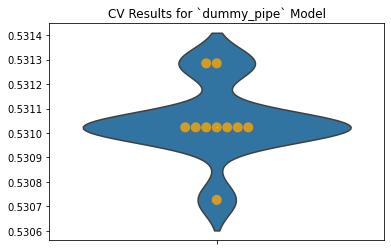

In [29]:
fig, ax = plt.subplots()

dummy_pipe.plot_cv(ax=ax);

In [30]:
dummy_pipe.print_cv_summary()

CV Results for `dummy_pipe` model:
            0.53105 ± 0.00015 accuracy
            recall_score: 0.0
            precision_score: 0.46895434857961904
            f1_score: 0.0    
        


#### Logistic Regression Pipeline

In [48]:
logreg_model_pipe = Pipeline(steps=[
    ('ct', ct),
    ('logreg', LogisticRegression(random_state=42, max_iter=1000))
])

In [49]:
logreg_model_pipe.fit(X_train1, y_train1);

#### Bringing in Our Modeling Class from before

In [50]:
log_pipe = ModelWithCV(logreg_model_pipe, model_name='log_pipe', X=X_train1, y=y_train1)

In [37]:
log_pipe.print_cv_summary()

CV Results for `log_pipe` model:
            0.77718 ± 0.01162 accuracy
            recall_score: 0.7466334638742267
            precision_score: 0.8286463637855354
            f1_score: 0.7586460472504087    
        


In [51]:
log_pickle = 'tuned_logreg.sav'
pickle.dump(log_pipe, open(log_pickle, 'wb'))

##### Logistic Regression Tuning

In [38]:
params = {}

params['logreg__solver'] = ['liblinear', 'sag']
params['logreg__C'] = [.1,.3,.5]
params['logreg__max_iter'] = [1, 5, 10]

In [39]:
gs_log = GridSearchCV(estimator=logreg_model_pipe, param_grid=params, cv=10)

In [40]:
gs_log.fit(X_train1, y_train1);

In [41]:
gs_log.cv_results_['mean_test_score']

array([0.76538458, 0.7421907 , 0.77706509, 0.77387948, 0.77706509,
       0.77728852, 0.76549628, 0.73811096, 0.77751208, 0.77114127,
       0.77751208, 0.7772324 , 0.76549625, 0.73816654, 0.77734426,
       0.77142119, 0.77734426, 0.77684122])

In [42]:
gs_log.best_params_

{'logreg__C': 0.3, 'logreg__max_iter': 5, 'logreg__solver': 'liblinear'}

Best parameters  for logreg: 'logreg__C': 0.3, 'logreg__max_iter': 50, 'logreg__solver': 'liblinear'

In [43]:
gs_log.best_estimator_

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  Index(['behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings',...
                                                  Pipeline(steps=[('num_impute',
                                                            

In [52]:
tuned_logreg_pipe = Pipeline(steps=[
    ('ct', ct),
    ('logreg', LogisticRegression(random_state=42, max_iter=5, solver='liblinear', C=.3))
])

In [53]:
tlog_pipe = ModelWithCV(tuned_logreg_pipe, model_name='tlog_pipe', X=X_train1, y=y_train1)

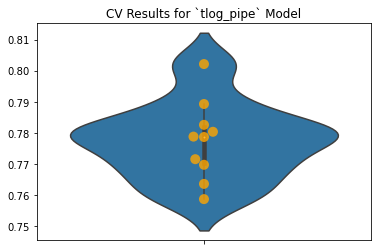

In [46]:
fig, ax = plt.subplots()

tlog_pipe.plot_cv(ax=ax);

In [47]:
tlog_pipe.print_cv_summary()

CV Results for `tlog_pipe` model:
            0.77751 ± 0.01195 accuracy
            recall_score: 0.7461571315057609
            precision_score: 0.8288517338281706
            f1_score: 0.7587960505203576    
        


Pickle and save model.

In [48]:
tlog_pickle = 'tuned_logreg.sav'
pickle.dump(tlog_pipe, open(tlog_pickle, 'wb'))

In [40]:
# Accessing one-hot encoded feature names
ohe_col_names = logreg_model_pipe.named_steps['ct'].named_transformers_['subpipe_cat']['ohe'].get_feature_names_out()

# Converting to list
ohe_cat_cols = ohe_col_names.tolist()

NameError: name 'logreg_model_pipe' is not defined

In [249]:
num_cols

['h1n1_concern',
 'h1n1_knowledge',
 'opinion_h1n1_vacc_effective',
 'opinion_h1n1_risk',
 'opinion_h1n1_sick_from_vacc',
 'opinion_seas_vacc_effective',
 'opinion_seas_risk',
 'opinion_seas_sick_from_vacc']

In [252]:
post_ct_cols = ohe_cat_cols + num_cols

#### Nearest Neighbors Pipeline

In [49]:
pd.DataFrame(ct.fit_transform(X_train1)).describe()

,0,1,2,3,4,5,6,7,8,9,...,88,89,90,91,92,93,94,95,96,97
count,17893.000000,17893.000000,17893.000000,17893.000000,17893.000000,17893.000000,17893.000000,17893.000000,17893.000000,17893.000000,...,17893.000000,17893.000000,1.789300e+04,1.789300e+04,1.789300e+04,1.789300e+04,1.789300e+04,1.789300e+04,1.789300e+04,1.789300e+04
mean,0.048902,0.725591,0.069692,0.821942,0.356564,0.337898,0.675124,0.203487,0.306041,0.275136,...,0.065445,0.009277,2.422350e-17,-1.052332e-16,3.027937e-17,7.981841e-17,-5.956598e-18,5.797756e-17,1.111898e-17,-4.487304e-17
std,0.215669,0.446228,0.254634,0.382573,0.478998,0.473007,0.468341,0.402603,0.460860,0.446595,...,0.247316,0.095874,1.000028e+00,1.000028e+00,1.000028e+00,1.000028e+00,1.000028e+00,1.000028e+00,1.000028e+00,1.000028e+00
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-1.788306e+00,-2.049421e+00,-2.853217e+00,-1.051483e+00,-1.002707e+00,-2.833489e+00,-1.245505e+00,-8.452392e-01
25%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-6.865928e-01,-4.259798e-01,-8.528797e-01,-1.051483e+00,-1.002707e+00,-3.039182e-02,-5.188961e-01,-8.452392e-01
50%,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,4.151205e-01,-4.259798e-01,1.472892e-01,-2.704224e-01,-2.659226e-01,-3.039182e-02,-5.188961e-01,-8.946163e-02
75%,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,...,0.000000,0.000000,4.151205e-01,1.197462e+00,1.147458e+00,1.291698e+00,1.207646e+00,9.039739e-01,9.343216e-01,-8.946163e-02
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.516834e+00,1.197462e+00,1.147458e+00,2.072758e+00,1.944430e+00,9.039739e-01,1.660931e+00,2.177871e+00


In [176]:
knn = KNeighborsClassifier()
knn_model_pipe = Pipeline([('ct', ct), ('knn', knn)]) 

In [177]:
knn_pipe = ModelWithCV(knn_model_pipe, 'knn_pipe', X_train1, y_train1)

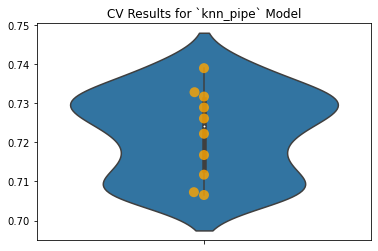

In [52]:
fig, ax = plt.subplots()

knn_pipe.plot_cv(ax=ax);

In [178]:
knn_pipe.print_cv_summary()

CV Results for `knn_pipe` model:
            0.72230 ± 0.01073 accuracy
            recall_score: 0.7126701288381861
            precision_score: 0.7137761625386754
            f1_score: 0.7065149188240983    
        


##### Nearest Neighbors Tuning

In [179]:
params = {}

params['knn__metric'] = ['euclidean', 'manhattan']
params['knn__n_neighbors'] = [175, 200, 225]

In [180]:
gs_knn = GridSearchCV(estimator=knn_model_pipe, param_grid=params, cv=10)

In [181]:
gs_knn.fit(X_train1, y_train1);

In [57]:
gs_knn.cv_results_['mean_test_score']

array([0.75510101, 0.75470969, 0.75487701, 0.75962733, 0.76085719,
       0.75733627])

In [182]:
gs_knn.best_params_

{'knn__metric': 'manhattan', 'knn__n_neighbors': 200}

knn best perameters: 'knn__metric': 'manhattan', 'knn__n_neighbors':200

In [183]:
gs_knn.best_estimator_

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  Index(['behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings',...
                                                  Pipeline(steps=[('num_impute',
                                                            

In [59]:
tuned_knn_pipe = Pipeline([('ct', ct), ('knn', KNeighborsClassifier(metric='manhattan', n_neighbors=200))]) 

In [60]:
tknn_pipe = ModelWithCV(tuned_knn_pipe, 'tknn_pipe', X_train1, y_train1)

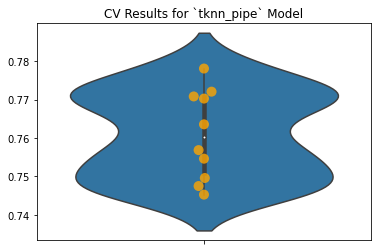

In [61]:
fig, ax = plt.subplots()

tknn_pipe.plot_cv(ax=ax);

In [62]:
tknn_pipe.print_cv_summary()

CV Results for `tknn_pipe` model:
            0.76086 ± 0.01106 accuracy
            recall_score: 0.7558094954310688
            precision_score: 0.8099638161731366
            f1_score: 0.7478056299135101    
        


Pickle and save.

In [63]:
tknn_pickle = 'tuned_knn.sav'
pickle.dump(tknn_pipe, open(tknn_pickle, 'wb'))

#### Random Forest Pipeline

In [54]:
# rfc!
rfc = RandomForestClassifier(random_state=42)
rfc_model_pipe = Pipeline([('ct', ct), ('rfc', rfc)])

In [55]:
forest_pipe = ModelWithCV(rfc_model_pipe, 'forest_pipe', X_train1, y_train1)

In [62]:
forest_pickle = '../forest.sav'
pickle.dump(forest_pipe, open(forest_pickle, 'wb'))

In [57]:
forest_pipe.print_cv_summary()

CV Results for `forest_pipe` model:
            0.77153 ± 0.01219 accuracy
            recall_score: 0.7391263692604574
            precision_score: 0.8263930425720363
            f1_score: 0.7521140408449998    
        


##### Random Forest Tuning

In [166]:
params = {}

params['rfc__max_features'] = ['sqrt']
params['rfc__n_estimators'] = [1000, 1250, 1500]

In [167]:
gs_rfc = GridSearchCV(estimator=rfc_model_pipe, param_grid=params, cv=10)

In [168]:
gs_rfc.fit(X_train1, y_train1); #11m

In [169]:
gs_rfc.cv_results_['mean_test_score']

array([0.77689743, 0.77728839, 0.77656192])

In [170]:
gs_rfc.best_params_

{'rfc__max_features': 'sqrt', 'rfc__n_estimators': 1250}

Random Forest best params: 'rfc__max_features': 'sqrt', 'rfc__n_estimators': 1250

In [58]:
rfc = RandomForestClassifier(random_state=42)
tuned_rfc_pipe = Pipeline([('ct', ct), ('rfc', RandomForestClassifier(random_state=42, max_features='sqrt', n_estimators=1250))])

In [59]:
tforest_pipe = ModelWithCV(tuned_rfc_pipe, 'tforest_pipe', X_train1, y_train1) #10m 35s

In [60]:
tforest_pipe.print_cv_summary() #6.5m

CV Results for `tforest_pipe` model:
            0.77706 ± 0.01164 accuracy
            recall_score: 0.7499721891140246
            precision_score: 0.8336055852918713
            f1_score: 0.759324132932402    
        


Pickle and save.

In [61]:
tforest_pickle = '../tuned_forest.sav'
pickle.dump(tforest_pipe, open(tforest_pickle, 'wb'))

#### Gradient Booster

In [78]:
gbc = GradientBoostingClassifier(random_state=42)
gbc_model_pipe = Pipeline([('ct', ct), ('gbc', gbc)])

In [79]:
boost_pipe = ModelWithCV(model=gbc_model_pipe,
                         model_name='boost_pipe',
                         X=X_train1,
                         y=y_train1)

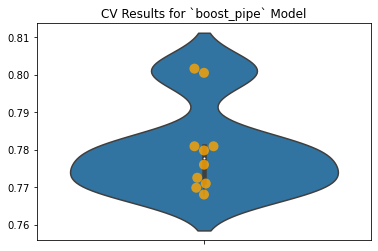

In [80]:
fig, ax = plt.subplots()

boost_pipe.plot_cv(ax=ax);

In [81]:
boost_pipe.print_cv_summary()

CV Results for `boost_pipe` model:
            0.78008 ± 0.01134 accuracy
            recall_score: 0.750687468074238
            precision_score: 0.8334631002183975
            f1_score: 0.7620078356718321    
        


##### Gradient Booster Tuning

In [82]:
params = {}

params['gbc__learning_rate'] = [.025, .05, .1]
params['gbc__n_estimators'] = [300, 350, 400]

In [83]:
gs_gbc = GridSearchCV(estimator=gbc_model_pipe, param_grid=params, cv=10)

In [84]:
gs_gbc.fit(X_train1, y_train1);

In [85]:
gs_gbc.cv_results_['mean_test_score']

array([0.77807099, 0.77874153, 0.78047428, 0.78075399, 0.78148031,
       0.78058583, 0.78047403, 0.78075339, 0.77974759])

In [86]:
gs_gbc.best_params_

{'gbc__learning_rate': 0.05, 'gbc__n_estimators': 350}

Gradient Booster best parmeters: 'gbc__learning_rate': 0.05, 'gbc__n_estimators': 350

In [89]:
gbc = GradientBoostingClassifier(random_state=42, learning_rate=.05, n_estimators=350)
tuned_gbc_pipe = Pipeline([('ct', ct), ('gbc', gbc)])

In [90]:
tgbc_pipe = ModelWithCV(model=tuned_gbc_pipe,
                         model_name='tgbc_pipe',
                         X=X_train1,
                         y=y_train1)

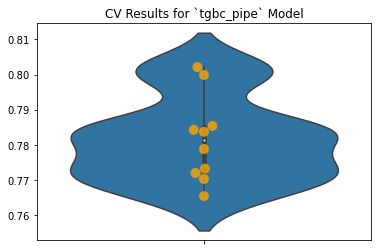

In [91]:
fig, ax = plt.subplots()

tgbc_pipe.plot_cv(ax=ax);

In [92]:
tgbc_pipe.print_cv_summary()

CV Results for `tgbc_pipe` model:
            0.78148 ± 0.01160 accuracy
            recall_score: 0.7530704069470457
            precision_score: 0.8352472411012861
            f1_score: 0.7637401536031916    
        


Pickle and save

In [93]:
tgbc_pickle = 'tuned_gboost.sav'
pickle.dump(tgbc_pipe, open(tgbc_pickle, 'wb'))

#### AdaBoost 

In [191]:
ada = AdaBoostClassifier()
ada_model_pipe = Pipeline([('ct', ct), ('ada', ada)])

In [192]:
ada_pipe = ModelWithCV(model=ada_model_pipe,
                         model_name='ada_pipe',
                         X=X_train1,
                         y=y_train1) #8s

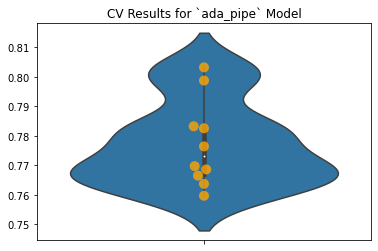

In [96]:
fig, ax = plt.subplots()

ada_pipe.plot_cv(ax=ax);

In [193]:
ada_pipe.print_cv_summary() #23s

CV Results for `ada_pipe` model:
            0.77723 ± 0.01395 accuracy
            recall_score: 0.7368603496225666
            precision_score: 0.8289267340215444
            f1_score: 0.7562475848416511    
        


##### Adaboost Tuning

In [213]:
params = {}

params['ada__learning_rate'] = [1, 1.25, 1.5]
params['ada__n_estimators'] = [150, 200, 225]

In [214]:
gs_ada = GridSearchCV(estimator=ada_model_pipe, param_grid=params, cv=10)

In [215]:
gs_ada.fit(X_train1, y_train1); #5m

In [101]:
gs_ada.cv_results_['mean_test_score']

array([0.77846224, 0.77857394, 0.77807092, 0.77790308, 0.77818241,
       0.77885311, 0.77896487, 0.77879727, 0.77885314])

In [216]:
gs_ada.best_params_

{'ada__learning_rate': 1.25, 'ada__n_estimators': 200}

Adaboost best parameters: 'ada__learning_rate': 1.25, 'ada__n_estimators': 200

In [198]:
gs_ada.best_estimator_

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  Index(['behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings',...
                                                  Pipeline(steps=[('num_impute',
                                                            

In [217]:
tuned_ada_pipe = Pipeline([('ct', ct), ('ada', AdaBoostClassifier(learning_rate=1.25, n_estimators=200))])

In [218]:
tada_pipe = ModelWithCV(model=tuned_ada_pipe,
                         model_name='tada_pipe',
                         X=X_train1,
                         y=y_train1) #42s

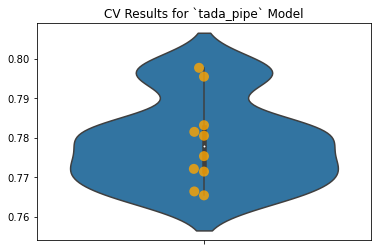

In [105]:
fig, ax = plt.subplots()

tada_pipe.plot_cv(ax=ax);

In [219]:
tada_pipe.print_cv_summary() #2m 5s

CV Results for `tada_pipe` model:
            0.77958 ± 0.01133 accuracy
            recall_score: 0.7396024178443725
            precision_score: 0.8310824545310005
            f1_score: 0.7588925692310653    
        


Pickle and save.

In [220]:
tada_pickle = 'tuned_ada.sav'
pickle.dump(tada_pipe, open(tada_pickle, 'wb'))

#### XGBoost 

In [121]:
xgb = xgboost.XGBClassifier(random_state=42, n_jobs=-1)
xgb_model_pipe = Pipeline([('ct', ct), ('xgb', xgb)])

In [122]:
xgb_pipe = ModelWithCV(model=xgb_model_pipe,
                         model_name='xgb_pipe',
                         X=X_train1,
                         y=y_train1)

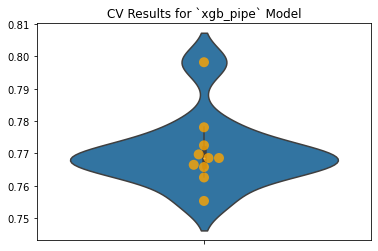

In [123]:
fig, ax = plt.subplots()

xgb_pipe.plot_cv(ax=ax);

In [124]:
xgb_pipe.print_cv_summary()

CV Results for `xgb_pipe` model:
            0.77058 ± 0.01081 accuracy
            recall_score: 0.7469921675463989
            precision_score: 0.8215447795616466
            f1_score: 0.7533516795955586    
        


##### XGBoost Tuning

In [125]:
params = {}

params['xgb__learning_rate'] = [.01, .05, .1]
params['xgb__n_estimators'] = [100, 150, 200]

In [128]:
gs_xgb = GridSearchCV(estimator=xgb_model_pipe, param_grid=params, cv=10)

In [129]:
gs_xgb.fit(X_train1, y_train1);

In [130]:
gs_xgb.cv_results_['mean_test_score']

array([0.76834626, 0.77046994, 0.7716435 , 0.77924467, 0.78058601,
       0.77941224, 0.78041839, 0.77952416, 0.77600289])

In [131]:
gs_xgb.best_params_

{'xgb__learning_rate': 0.05, 'xgb__n_estimators': 150}

Best parameters XGBoost: learning rate: .05, n_estimators: 150

In [132]:
gs_xgb.best_estimator_

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  Index(['behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings',...
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
               

In [133]:
tuned_xgb_pipe = Pipeline([('ct', ct), ('xgb', xgboost.XGBClassifier(random_state=42, learning_rate=.05, n_estimators=150))])

In [134]:
txgb_pipe = ModelWithCV(model=tuned_xgb_pipe,
                         model_name='txgb_pipe',
                         X=X_train1,
                         y=y_train1)

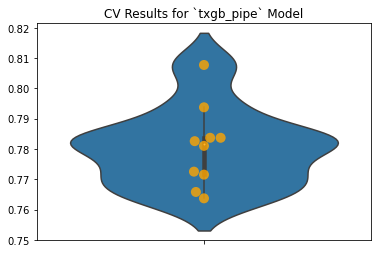

In [135]:
fig, ax = plt.subplots()

txgb_pipe.plot_cv(ax=ax);

In [136]:
txgb_pipe.print_cv_summary()

CV Results for `txgb_pipe` model:
            0.78059 ± 0.01259 accuracy
            recall_score: 0.7530699812702195
            precision_score: 0.8342093756891588
            f1_score: 0.763022810754403    
        


Pickle and save.

In [137]:
txgb_pickle = 'tuned_xgb.sav'
pickle.dump(txgb_pipe, open(txgb_pickle, 'wb'))

#### Extra Trees Classifier

In [63]:
etc = ExtraTreesClassifier(max_features='sqrt', max_samples=.5, bootstrap=True, random_state=42)
etc_model_pipe = Pipeline([('ct', ct), ('etc', etc)])

In [64]:
etc_pipe = ModelWithCV(model=etc_model_pipe,
                         model_name='etc_pipe',
                         X=X_train1,
                         y=y_train1) #10s

In [65]:
etc_pipe.print_cv_summary() #28s

CV Results for `etc_pipe` model:
            0.77058 ± 0.01184 accuracy
            recall_score: 0.733285941313355
            precision_score: 0.8226913437164194
            f1_score: 0.7498575863366292    
        


In [67]:
etc_pickle = '../etc.sav'
pickle.dump(etc_pipe, open(etc_pickle, 'wb'))

##### Extra Trees Tuning

In [204]:
params = {}

params['etc__max_depth'] = [25, 50, 100]
params['etc__n_estimators'] = [250, 500, 750]

In [205]:
gs_etc = GridSearchCV(estimator=etc_model_pipe, param_grid=params, cv=10)

In [206]:
gs_etc.fit(X_train1, y_train1); #6m

In [145]:
gs_etc.cv_results_['mean_test_score']

array([0.77376734, 0.77421443, 0.77432647, 0.77427085, 0.77488525,
       0.77359965, 0.77371191, 0.7746617 , 0.77399087])

In [207]:
gs_etc.best_params_

{'etc__max_depth': 50, 'etc__n_estimators': 500}

Best parameters Extra Trees: max_depth: 50, n_estimators: 500

In [68]:
tuned_etc_pipe = Pipeline([('ct', ct), ('etc', ExtraTreesClassifier(max_features='sqrt', max_samples=.5, bootstrap=True, random_state=42, max_depth=50, n_estimators=500))])

In [69]:
tetc_pipe = ModelWithCV(model=tuned_etc_pipe,
                         model_name='tetc_pipe',
                         X=X_train1,
                         y=y_train1) #2m 32s

In [70]:
tetc_pipe.print_cv_summary()

CV Results for `tetc_pipe` model:
            0.77399 ± 0.01175 accuracy
            recall_score: 0.740079743458766
            precision_score: 0.8302410092727717
            f1_score: 0.7543782442015724    
        


Pickle and save

In [71]:
tetc_pickle = '../tuned_etc.sav'
pickle.dump(tetc_pipe, open(tetc_pickle, 'wb'))

#### Bagging

In [146]:
bag = BaggingClassifier(n_estimators=100, random_state=42)
bag_model_pipe = Pipeline([('ct', ct), ('bag', bag)])

In [153]:
bag_pipe = ModelWithCV(model=bag_model_pipe,
                         model_name='bag_pipe',
                         X=X_train1,
                         y=y_train1)

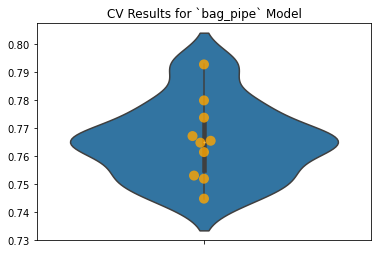

In [154]:
fig, ax = plt.subplots()

bag_pipe.plot_cv(ax=ax);

In [155]:
bag_pipe.print_cv_summary()

CV Results for `bag_pipe` model:
            0.76538 ± 0.01343 accuracy
            recall_score: 0.7396039786594018
            precision_score: 0.8045860551152391
            f1_score: 0.7473036893495382    
        


##### Bagging

In [150]:
params = {}

params['bag__max_features'] = [25, 50, 100]
params['bag__n_estimators'] = [100, 500, 750]

In [151]:
gs_bag = GridSearchCV(estimator=bag_model_pipe, param_grid=params, cv=10)

In [152]:
gs_bag.fit(X_train1, y_train1);

/Users/zachrauch/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
30 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/zachrauch/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/zachrauch/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/zachrauch/opt/anaconda3/envs/learn-env/lib/python3.

In [153]:
gs_bag.best_params_

{'bag__max_features': 50, 'bag__n_estimators': 500}

##### Bagging Tuned

In [156]:
bag = BaggingClassifier(max_features= 50,n_estimators=500, random_state=42)
tbag_model_pipe = Pipeline([('ct', ct), ('bag', bag)])

In [157]:
tbag_pipe = ModelWithCV(model=tbag_model_pipe,
                         model_name='bag_pipe',
                         X=X_train1,
                         y=y_train1)

In [158]:
tbag_pipe.print_cv_summary()

CV Results for `bag_pipe` model:
            0.77343 ± 0.01100 accuracy
            recall_score: 0.7349547363641522
            precision_score: 0.8248506246930465
            f1_score: 0.7526427600886357    
        


### Ensembles

#### Voting Classifier

##### Voting Classifier 1

In [230]:
estimators=[
    ('logreg', LogisticRegression(random_state=42, max_iter=5, solver='liblinear', C=.3)),
    ('knn', KNeighborsClassifier(metric='manhattan', n_neighbors=200)),
    ('rfc', RandomForestClassifier(random_state=42, max_features='sqrt', n_estimators=1250)) 
]

In [231]:
avg1 = VotingClassifier(estimators=estimators, voting='soft')
avg1_model_pipe = Pipeline([('ct', ct), ('avg1', avg1)])

In [232]:
avg1_pipe = ModelWithCV(model=avg1_model_pipe,
                         model_name='avg1_pipe',
                         X=X_train1,
                         y=y_train1) #3m 9s

In [233]:
avg1_model = 'avg1_model.sav'
pickle.dump(avg1_pipe, open(avg1_model, 'wb'))

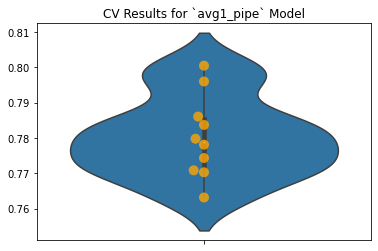

In [51]:
fig, ax = plt.subplots()

avg1_pipe.plot_cv(ax=ax);

In [234]:
avg1_pipe.print_cv_summary() #9m 6s

CV Results for `avg1_pipe` model:
            0.78042 ± 0.01113 accuracy
            recall_score: 0.7571217151938248
            precision_score: 0.8315395769883077
            f1_score: 0.7638374022426514    
        
None


In [236]:
avg1_summary

In [237]:
avg1_model_summary = 'avg1_model_summary.sav'
pickle.dump(avg1_pipe.print_cv_summary(), open(avg1_model_summary, 'wb'))

CV Results for `avg1_pipe` model:
            0.78042 ± 0.01113 accuracy
            recall_score: 0.7571217151938248
            precision_score: 0.8315395769883077
            f1_score: 0.7638374022426514    
        


##### Voting Classifier 2

In [72]:
estimators=[
    ('rfc', RandomForestClassifier(random_state=42, max_features='sqrt', n_estimators=1250)),
    ('etc', ExtraTreesClassifier(max_features='sqrt', max_samples=.5, bootstrap=True, random_state=42, max_depth=50, n_estimators=500))
]

In [73]:
avg2 = VotingClassifier(estimators=estimators, voting='soft')
avg2_model_pipe = Pipeline([('ct', ct), ('avg2', avg2)])

In [74]:
avg2_pipe = ModelWithCV(model=avg2_model_pipe,
                         model_name='avg2_pipe',
                         X=X_train1,
                         y=y_train1) #12m 48s

In [75]:
avg2_model = '../avg2_model.sav'
pickle.dump(avg2_pipe, open(avg2_model, 'wb'))

In [73]:
avg2_model_pipe.fit(X_train1, y_train1);

### Feature Importance

In [76]:
avg2_model_pipe.fit(X_train1, y_train1);

In [77]:
# Accessing one-hot encoded feature names
ohe_col_names = avg2_model_pipe.named_steps['ct'].named_transformers_['subpipe_cat']['ohe'].get_feature_names_out()

# Converting to list
ohe_cat_cols = ohe_col_names.tolist()

In [78]:
post_ct_cols = ohe_cat_cols + num_cols

['x0_1.0',
 'x1_1.0',
 'x2_1.0',
 'x3_1.0',
 'x4_1.0',
 'x5_1.0',
 'x6_1.0',
 'x7_1.0',
 'x8_1.0',
 'x9_1.0',
 'x10_1.0',
 'x11_1.0',
 'x12_1',
 'x12_Unknown',
 'x13_35 - 44 Years',
 'x13_45 - 54 Years',
 'x13_55 - 64 Years',
 'x13_65+ Years',
 'x14_< 12 Years',
 'x14_College Graduate',
 'x14_Some College',
 'x15_Hispanic',
 'x15_Other or Multiple',
 'x15_White',
 'x16_Male',
 'x17_> $75,000',
 'x17_Below Poverty',
 'x18_Not Married',
 'x19_Rent',
 'x20_Not in Labor Force',
 'x21_bhuqouqj',
 'x21_dqpwygqj',
 'x21_fpwskwrf',
 'x21_kbazzjca',
 'x21_lrircsnp',
 'x21_lzgpxyit',
 'x21_mlyzmhmf',
 'x21_oxchjgsf',
 'x21_qufhixun',
 'x22_MSA, Principle City',
 'x22_Non-MSA',
 'x23_1.0',
 'x23_2.0',
 'x23_3.0',
 'x24_1.0',
 'x24_2.0',
 'x24_3.0',
 'x25_arjwrbjb',
 'x25_atmlpfrs',
 'x25_cfqqtusy',
 'x25_dotnnunm',
 'x25_fcxhlnwr',
 'x25_haxffmxo',
 'x25_ldnlellj',
 'x25_mcubkhph',
 'x25_mfikgejo',
 'x25_msuufmds',
 'x25_nduyfdeo',
 'x25_phxvnwax',
 'x25_pxcmvdjn',
 'x25_qnlwzans',
 'x25_rucpziij

In [79]:
X_post = pd.DataFrame(avg2_model_pipe.named_steps['ct'].fit_transform(X_train1,y_train1), columns=post_ct_cols)

In [80]:
for alg in avg2_model_pipe.named_steps['avg2'].named_estimators:
    clf = avg2_model_pipe.named_steps['avg2'].named_estimators[alg]
    feat_imp = clf.fit(X_post, y_train1).feature_importances_
feat_imp

array([0.00545263, 0.01332739, 0.00672429, 0.01118781, 0.01442258,
       0.01423219, 0.01462696, 0.01793817, 0.07119031, 0.01780665,
       0.00731026, 0.01097684, 0.01619444, 0.01152804, 0.0088794 ,
       0.00999042, 0.01227932, 0.0384391 , 0.00755622, 0.01448668,
       0.01287125, 0.00535168, 0.00554289, 0.01278438, 0.01591985,
       0.01276278, 0.00829364, 0.0147148 , 0.01292065, 0.01297172,
       0.00961672, 0.00502454, 0.01029969, 0.00944095, 0.00812523,
       0.01149702, 0.00761837, 0.00974575, 0.0099004 , 0.01488956,
       0.01463813, 0.01500052, 0.00862333, 0.00457103, 0.00941438,
       0.0080967 , 0.00648108, 0.00421641, 0.00376179, 0.00179779,
       0.00118682, 0.00800881, 0.00256799, 0.00434235, 0.00136596,
       0.00330858, 0.00098435, 0.00138368, 0.00071639, 0.00356754,
       0.00010499, 0.00230343, 0.00159397, 0.00270777, 0.0011915 ,
       0.00563462, 0.00319244, 0.00255724, 0.00203676, 0.00187727,
       0.00472114, 0.00265722, 0.00131717, 0.00439799, 0.00145

In [81]:
A = pd.DataFrame()

In [82]:
A['Features'] = post_ct_cols

In [83]:
A['Feature_importance'] = feat_imp

In [84]:
A.sort_values('Feature_importance', ascending=False).head(10)

,Features,Feature_importance
97,opinion_seas_risk,0.073407
8,x8_1.0,0.071190
96,opinion_seas_vacc_effective,0.064587
17,x13_65+ Years,0.038439
94,opinion_h1n1_risk,0.029668
93,opinion_h1n1_vacc_effective,0.026548
98,opinion_seas_sick_from_vacc,0.023892
91,h1n1_concern,0.023393
95,opinion_h1n1_sick_from_vacc,0.021370
92,h1n1_knowledge,0.020897


x8_1.0 = Doctor Recommended

##### Voting Classifier 3

In [153]:
estimators=[
    ('rfc', RandomForestClassifier(random_state=42, max_features='sqrt', n_estimators=1250)),
    ('gbc', GradientBoostingClassifier(random_state=42, learning_rate=.05, n_estimators=350)),
    ('ada', AdaBoostClassifier(learning_rate=1.25, n_estimators=200)),
    ('xgb', xgboost.XGBClassifier(random_state=42, learning_rate=.05, n_estimators=150)),
    ('etc', ExtraTreesClassifier(max_features='sqrt', max_samples=.5, bootstrap=True, random_state=42, max_depth=50, n_estimators=500))
]

In [154]:
avg3 = VotingClassifier(estimators=estimators, voting='soft')
avg3_model_pipe = Pipeline([('ct', ct), ('avg3', avg3)])

In [155]:
avg3_pipe = ModelWithCV(model=avg3_model_pipe,
                         model_name='avg3_pipe',
                         X=X_train1,
                         y=y_train1) #6m 17s

In [156]:
avg3_model = 'avg3_model.sav'
pickle.dump(avg3_pipe, open(avg3_model, 'wb'))

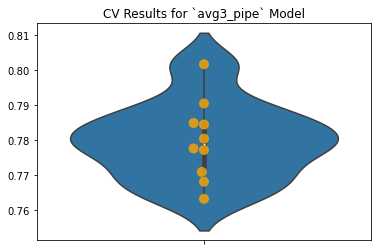

In [122]:
fig, ax = plt.subplots()

avg3_pipe.plot_cv(ax=ax);

In [157]:
avg3_summary = avg3_pipe.print_cv_summary()

#pickle.dump(avg3_summary, open(avg3_model, 'wb')) #15m 52s

CV Results for `avg3_pipe` model:
            0.78019 ± 0.01083 accuracy
            recall_score: 0.7527122708439753
            precision_score: 0.8351519934133187
            f1_score: 0.7625728854560864    
        


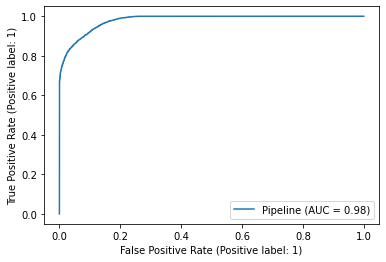

In [161]:
plot_roc_curve(avg3_model_pipe.fit(X_train1, y_train1), X_train1, y_train1); #42s

#### Weighted Voting Classifier

#### Stacking

##### Stack 1

In [41]:
estimators=[
    ('rfc', RandomForestClassifier(random_state=42, max_features='sqrt', n_estimators=1250)),
    ('etc', ExtraTreesClassifier(max_features='sqrt', max_samples=.5, bootstrap=True, random_state=42, max_depth=50, n_estimators=500))
]

In [42]:
sr1 = StackingClassifier(estimators)
sr1_model_pipe = Pipeline([('ct', ct), ('sr1', sr1)])

In [44]:
sr1_pipe = ModelWithCV(model=sr1_model_pipe,
                         model_name='sr1_pipe',
                         X=X_train1,
                         y=y_train1)

KeyboardInterrupt: 

In [ ]:
sr1_cv_summary = sr1_pipe.print_cv_summary()

Pickle and save.

In [30]:
sr1_pickle = 'stack_1.sav'
pickle.dump(sr1_model_pipe, open(sr1_pickle, 'wb'))

##### Stack 2

In [31]:
estimators=[
    ('rfc', RandomForestClassifier(random_state=42, max_features='sqrt', n_estimators=1000)),
    ('etc', ExtraTreesClassifier(max_features='sqrt', max_samples=.5, bootstrap=True, random_state=42, max_depth=50, n_estimators=500))
]

In [32]:
sr2 = StackingClassifier(estimators)
sr2_model_pipe = Pipeline([('ct', ct), ('sr2', sr2)])

In [34]:
sr2_pipe = ModelWithCV(model=sr2_model_pipe,
                         model_name='sr2_pipe',
                         X=X_train1,
                         y=y_train1)

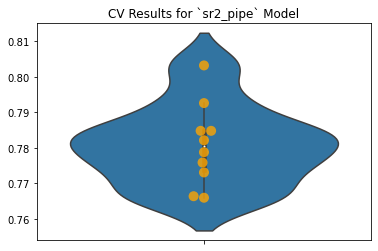

In [35]:
fig, ax = plt.subplots()

sr2_pipe.plot_cv(ax=ax);

In [68]:
sr2_cv_summary = sr2_pipe.print_cv_summary()

CV Results for `sr2_pipe` model:
            0.78075 ± 0.01094 accuracy
            recall_score: 0.7521168908564617
            precision_score: 0.8332175464642955
            f1_score: 0.7629245422589148    
        


In [69]:
sr2_cv_summary = 'sr2_cv_summary.sav'
pickle.dump(sr2_cv_summary, open(sr2_cv_summary, 'wb'))

Pickle and save.

In [36]:
sr2_pickle = 'stack_2.sav'
pickle.dump(sr2_model_pipe, open(sr2_pickle, 'wb'))

##### Stack 3

In [37]:
estimators=[
    ('logreg', LogisticRegression(random_state=42, max_iter=5, solver='liblinear', C=.3)),
    ('knn', KNeighborsClassifier(metric='manhattan', n_neighbors=200)),
    ('rfc', RandomForestClassifier(random_state=42, max_features='sqrt', n_estimators=1000)),
    ('gbc', GradientBoostingClassifier(random_state=42, learning_rate=.05, n_estimators=350)),
    ('ada', AdaBoostClassifier(learning_rate=.75, n_estimators=350)),
    ('xgb', xgboost.XGBClassifier(random_state=42, learning_rate=.05, n_estimators=150)),
    ('etc', ExtraTreesClassifier(max_features='sqrt', max_samples=.5, bootstrap=True, random_state=42, max_depth=50, n_estimators=500))
]

In [38]:
sr3 = StackingClassifier(estimators)
sr3_model_pipe = Pipeline([('ct', ct), ('sr3', sr3)])

In [39]:
sr3_pipe = ModelWithCV(model=sr3_model_pipe,
                         model_name='sr3_pipe',
                         X=X_train1,
                         y=y_train1)

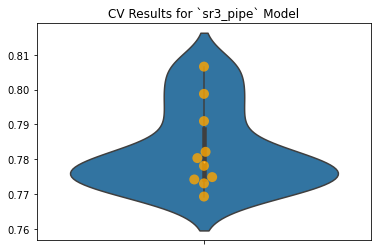

In [40]:
fig, ax = plt.subplots()

sr3_pipe.plot_cv(ax=ax);

In [44]:
sr3_pipe.print_cv_summary()

CV Results for `sr3_pipe` model:
            0.78282 ± 0.01154 accuracy
            recall_score: 0.7535474487768885
            precision_score: 0.8363984875876419
            f1_score: 0.7649424610464328    
        


In [70]:
sr3_cv_summary = sr3_pipe.print_cv_summary()

CV Results for `sr3_pipe` model:
            0.78282 ± 0.01154 accuracy
            recall_score: 0.7535474487768885
            precision_score: 0.8363984875876419
            f1_score: 0.7649424610464328    
        


In [71]:
sr3_cv_summary = 'sr3_cv_summary.sav'
pickle.dump(sr3_cv_summary, open(sr3_cv_summary, 'wb'))

Pickle and save.

In [41]:
sr3_pickle = 'stack_3.sav'
pickle.dump(sr3_model_pipe, open(sr3_pickle, 'wb'))

### Tune again?

### Evaluation on Test Set

In [270]:
final_model1 = avg2_model_pipe

In [272]:
final_model1.fit(X_train1, y_train1); #19s

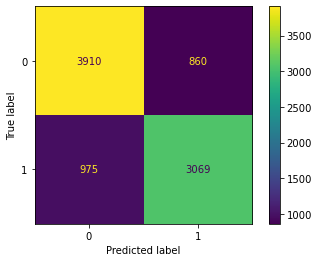

In [126]:
fm1_cm = plot_confusion_matrix(final_model1, X_test1, y_test1);

final1 = 'final1.sav'
pickle.dump(fm1_cm, open(final1, 'wb')) #14.5s

In [127]:
y_hat = final_model1.predict(X_test1) #15s

In [128]:
fm1_test_results = print(f"""
Our final model's accuracy on the test set is {round(accuracy_score(y_test1, y_hat), 2)}. \n
Our final model's recall on the test set is {round(recall_score(y_test1, y_hat), 2)} \n
Our final model's precision on the test set is {round(precision_score(y_test1, y_hat), 2)} \n
Our final model's f1-score on the test is {round(f1_score(y_test1, y_hat), 2)}.
""")

pickle.dump(fm1_test_results, open(final1, 'wb'))


Our final model's accuracy on the test set is 0.79. 

Our final model's recall on the test set is 0.76 

Our final model's precision on the test set is 0.78 

Our final model's f1-score on the test is 0.77.



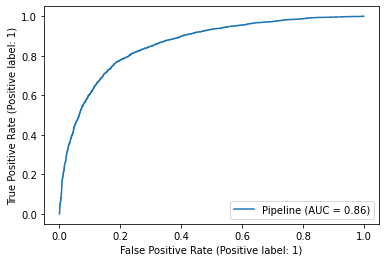

In [142]:
from sklearn.metrics import plot_roc_curve
fm1_roc_curve = plot_roc_curve(final_model1, X_test1, y_test1)

pickle.dump(fm1_roc_curve, open(final1, 'wb')) #15s

In [130]:
y_hat = final_model1.predict_proba(X_test1)[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test1, y_hat)
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix])) #15s

Best Threshold=0.490578, G-Mean=0.790


In [131]:
y_hat = (final_model1.predict_proba(X_test1)[:,1] >= thresholds[ix]).astype(bool) #15s

In [132]:
fm1_test_results_with_thresh =print(f"""
Our final model's accuracy on the test set is {round(accuracy_score(y_test1, y_hat), 2)}. \n
Our final model's recall on the test set is {round(recall_score(y_test1, y_hat), 2)} \n
Our final model's precision on the test set is {round(precision_score(y_test1, y_hat), 2)} \n
Our final model's f1-score on the test is {round(f1_score(y_test1, y_hat), 2)}.
""")

pickle.dump(fm1_test_results_with_thresh, open(final1, 'wb'))


Our final model's accuracy on the test set is 0.79. 

Our final model's recall on the test set is 0.77 

Our final model's precision on the test set is 0.78 

Our final model's f1-score on the test is 0.77.



Final part 2

In [162]:
final_model2 = avg3_model_pipe

In [163]:
final_model2.fit(X_train1, y_train1); #35s

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  Index(['behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings',...
                                                             monotone_constraints=None,
                                                     

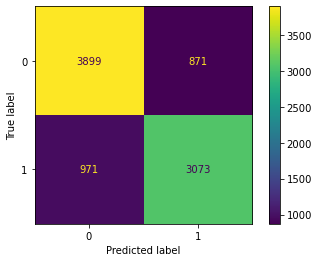

In [164]:
fm2_cm = plot_confusion_matrix(final_model2, X_test1, y_test1);

final2 = 'final2.sav'
pickle.dump(fm2_cm, open(final2, 'wb')) #3s

In [165]:
y_hat = final_model2.predict(X_test1) #3s

In [166]:
fm2_test_results = print(f"""
Our final model's accuracy on the test set is {round(accuracy_score(y_test1, y_hat), 2)}. \n
Our final model's recall on the test set is {round(recall_score(y_test1, y_hat), 2)} \n
Our final model's precision on the test set is {round(precision_score(y_test1, y_hat), 2)} \n
Our final model's f1-score on the test is {round(f1_score(y_test1, y_hat), 2)}.
""")

pickle.dump(fm2_test_results, open(final2, 'wb'))


Our final model's accuracy on the test set is 0.79. 

Our final model's recall on the test set is 0.76 

Our final model's precision on the test set is 0.78 

Our final model's f1-score on the test is 0.77.



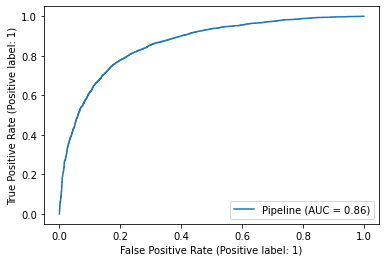

In [167]:
fm2_roc_curve = plot_roc_curve(final_model2, X_test1, y_test1)

pickle.dump(fm2_roc_curve, open(final2, 'wb')) #15s

In [168]:
y_hat = final_model2.predict_proba(X_test1)[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test1, y_hat)
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix])) #15s

Best Threshold=0.486700, G-Mean=0.790


In [169]:
y_hat = (final_model2.predict_proba(X_test1)[:,1] >= thresholds[ix]).astype(bool) #15s

In [170]:
fm2_test_results_with_thresh = print(f"""
Our final model's accuracy on the test set is {round(accuracy_score(y_test1, y_hat), 2)}. \n
Our final model's recall on the test set is {round(recall_score(y_test1, y_hat), 2)} \n
Our final model's precision on the test set is {round(precision_score(y_test1, y_hat), 2)} \n
Our final model's f1-score on the test is {round(f1_score(y_test1, y_hat), 2)}.
""")

pickle.dump(fm2_test_results_with_thresh, open(final2, 'wb'))


Our final model's accuracy on the test set is 0.79. 

Our final model's recall on the test set is 0.78 

Our final model's precision on the test set is 0.77 

Our final model's f1-score on the test is 0.77.

